<a href="https://colab.research.google.com/gist/cavidqlyv/bd4352f072f1e7a35db0a137d1fb0c9b/ecg-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries

In [1]:
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
from scipy import signal
import os
import imageio
from IPython.display import Image
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from math import sqrt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import random 
from keras.models import load_model
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
!pip install pyyaml h5py

#Dataset

## Download the data

In [3]:
!wget -nc https://maxime-devanne.com/datasets/ECG200/ECG200_TRAIN.tsv
!wget -nc : https://maxime-devanne.com/datasets/ECG200/ECG200_TEST.tsv

--2021-12-29 05:48:26--  https://maxime-devanne.com/datasets/ECG200/ECG200_TRAIN.tsv
Resolving maxime-devanne.com (maxime-devanne.com)... 213.186.33.4, 2001:41d0:1:1b00:213:186:33:4
Connecting to maxime-devanne.com (maxime-devanne.com)|213.186.33.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106739 (104K) [text/tab-separated-values]
Saving to: ‘ECG200_TRAIN.tsv’

ECG200_TRAIN.tsv    100%[===================>] 104.24K  --.-KB/s    in 0.03s   

2021-12-29 05:48:26 (3.88 MB/s) - ‘ECG200_TRAIN.tsv’ saved [106739/106739]

:: Scheme missing.
--2021-12-29 05:48:26--  https://maxime-devanne.com/datasets/ECG200/ECG200_TEST.tsv
Resolving maxime-devanne.com (maxime-devanne.com)... 213.186.33.4, 2001:41d0:1:1b00:213:186:33:4
Connecting to maxime-devanne.com (maxime-devanne.com)|213.186.33.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106740 (104K) [text/tab-separated-values]
Saving to: ‘ECG200_TEST.tsv’

ECG200_TEST.tsv     100%[=========

## Load the data

In [4]:
train = np.genfromtxt(fname="ECG200_TRAIN.tsv", delimiter="\t", filling_values=1)  # change filling_values as req'd to fill in missing values
test = np.genfromtxt(fname="ECG200_TEST.tsv", delimiter="\t", filling_values=1)  # change filling_values as req'd to fill in missing values

In [5]:
train.shape

(100, 97)

# Data Preprocessing

## transform labels

In [6]:
def transform_labels(y_train,y_test):
  """
  This function transforms non-binary classes to a binary representation
  For example if we have a list of 6 flowers each can have one of the 3 classes
  Input: [
           1, 
           3,
           3,
           2,
           1,
           2
          ]

  Output: [
           [1,0,0], # class 1 
           [0,0,1], # class 3
           [0,0,1], # class 3
           [0,1,0], # class 2
           [1,0,0], # class 1
           [0,1,0]  # class 2
          ]
  """

  print('y_train',y_train.shape) 
  print('y_test',y_test.shape) 

  # concatenate train and test
  y_train_test = np.concatenate((y_train,y_test),axis =0)

  # init encoder Label encoder 
  encoder = LabelEncoder()
  # transformer [1,3,3,2,1,2] to [0,2,2,1,0,1] 
  new_y_train_test = encoder.fit_transform(y_train_test)

  # init one-hot encoder
  encoder = OneHotEncoder()
  # transform [0,2,2,1,0,1] to binary representation
  new_y_train_test = encoder.fit_transform(new_y_train_test.reshape(-1,1))

  # resplit the train and test
  new_y_train = new_y_train_test[0:len(y_train)]
  new_y_test = new_y_train_test[len(y_train):]

  print('new_y_train',new_y_train.shape) 
  print('new_y_test',new_y_test.shape) 

  return new_y_train.toarray(), new_y_test.toarray()

## Train Test Split and X Y

In [7]:
print("train shape: ",train.shape)
print("test shape: ",test.shape)

train shape:  (100, 97)
test shape:  (100, 97)


In [8]:
def SplitXY(train,test):
  x_train = train[:,1:]
  y_train = train[:,0]

  x_test = test[:,1:]
  y_test = test[:,0]

  y_train,y_test = transform_labels(y_train,y_test)

  x_train = x_train.reshape(x_train.shape + (1,))
  x_test = x_test.reshape(x_test.shape + (1,))
  return x_train,y_train,x_test ,y_test

x_train,y_train,x_test ,y_test = SplitXY(train,test)

y_train (100,)
y_test (100,)
new_y_train (100, 2)
new_y_test (100, 2)


In [9]:
print("x_train :",x_train.shape)
print("y_train :",y_train.shape)

print("\nx_test :",x_test.shape)
print("y_test :",y_test.shape)

x_train : (100, 96, 1)
y_train : (100, 2)

x_test : (100, 96, 1)
y_test : (100, 2)


In [10]:
print("x_train std :",x_train.std())
print("x_train mean :",x_train.mean())
print("\nx_test std :",x_test.std())
print("x_test mean :",x_test.mean())

x_train std : 0.9947780323086644
x_train mean : 1.563919808470852e-10

x_test std : 0.9947780324022082
x_test mean : 1.432010406550906e-10


Division by class 

In [11]:
y_train.shape

(100, 2)

In [12]:
def divideClassed(x_train,y_train,x_test ,y_test,y_label=False):
  class1_train = x_train[y_train[:,0]==1]
  class2_train = x_train[y_train[:,0]==0]
  class1_test = x_test[y_test[:,0]==1]
  class2_test = x_test[y_test[:,0]==0]
  return class1_train, class2_train, class1_test, class2_test

class1_train, class2_train, class1_test, class2_test = divideClassed(x_train,y_train,x_test ,y_test)

print("class1 train shape: ", class1_train.shape)
print("class2 train shape: ", class2_train.shape)
print("\nclass1 test shape: ", class1_test.shape)
print("class2 test shape: ", class2_test.shape)

class1 train shape:  (31, 96, 1)
class2 train shape:  (69, 96, 1)

class1 test shape:  (36, 96, 1)
class2 test shape:  (64, 96, 1)


# Visualization of ECG

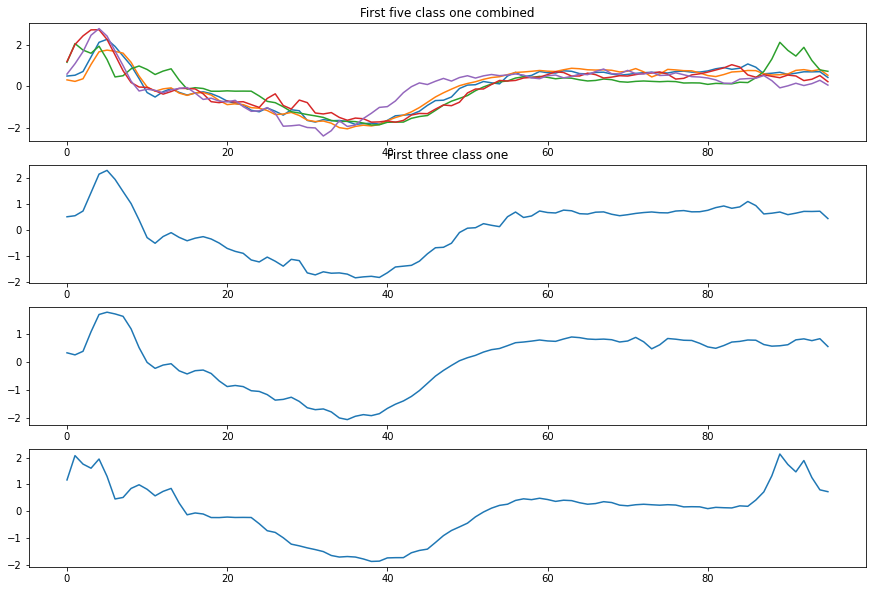

In [13]:
fig,axs = plt.subplots(4,figsize=(15,10))
axs[0].title.set_text('First five class one combined')

axs[0].plot(class1_train[0])
axs[0].plot(class1_train[1])
axs[0].plot(class1_train[2])
axs[0].plot(class1_train[3])
axs[0].plot(class1_train[4])

axs[1].title.set_text('First three class one')
axs[1].plot(class1_train[0])
axs[2].plot(class1_train[1])
axs[3].plot(class1_train[2])
plt.show()

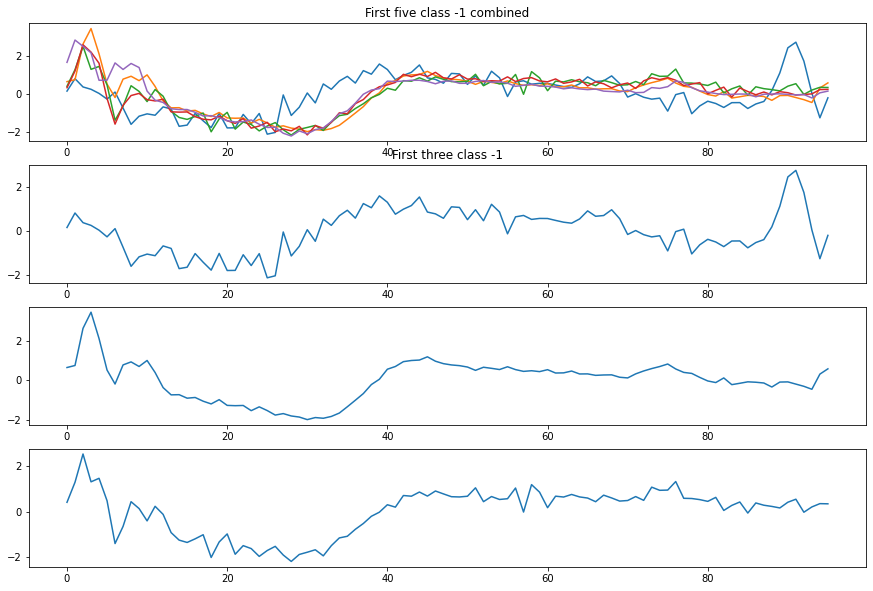

In [14]:
fig,axs = plt.subplots(4,figsize=(15,10))
axs[0].title.set_text('First five class -1 combined')

axs[0].plot(class2_train[0])
axs[0].plot(class2_train[1])
axs[0].plot(class2_train[2])
axs[0].plot(class2_train[3])
axs[0].plot(class2_train[4])

axs[1].title.set_text('First three class -1')
axs[1].plot(class2_train[0])
axs[2].plot(class2_train[1])
axs[3].plot(class2_train[2])

plt.show()

[]

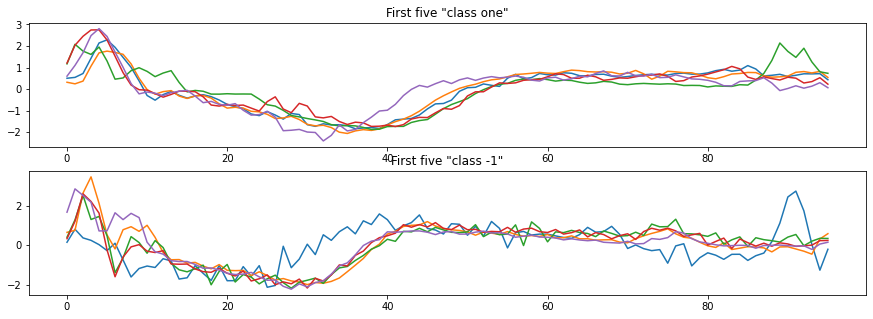

In [15]:
fig,axs = plt.subplots(2,figsize=(15,5))

axs[0].title.set_text('First five "class one"')
axs[0].plot(class1_train[0])
axs[0].plot(class1_train[1])
axs[0].plot(class1_train[2])
axs[0].plot(class1_train[3])
axs[0].plot(class1_train[4])

axs[1].title.set_text('First five "class -1"')
axs[1].plot(class2_train[0])
axs[1].plot(class2_train[1])
axs[1].plot(class2_train[2])
axs[1].plot(class2_train[3])
axs[1].plot(class2_train[4])
plt.plot()

[]

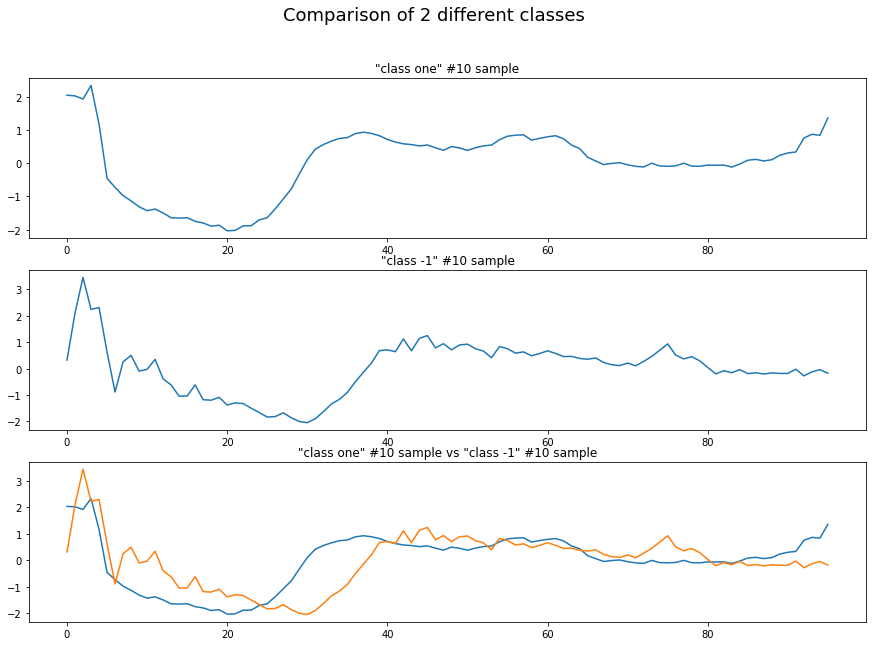

In [16]:
fig,axs = plt.subplots(3,figsize=(15,10))
fig.suptitle("Comparison of 2 different classes", fontsize=18)

c1 = 10
c2 = 10 

axs[0].title.set_text(f'"class one" #{c1} sample')
axs[0].plot(class1_train[c1])

axs[1].title.set_text(f'"class -1" #{c2} sample')
axs[1].plot(class2_train[c2])

axs[2].title.set_text(f'"class one" #{c1} sample vs "class -1" #{c2} sample')
axs[2].plot(class1_train[c1])
axs[2].plot(class2_train[c2])

plt.plot()

[]

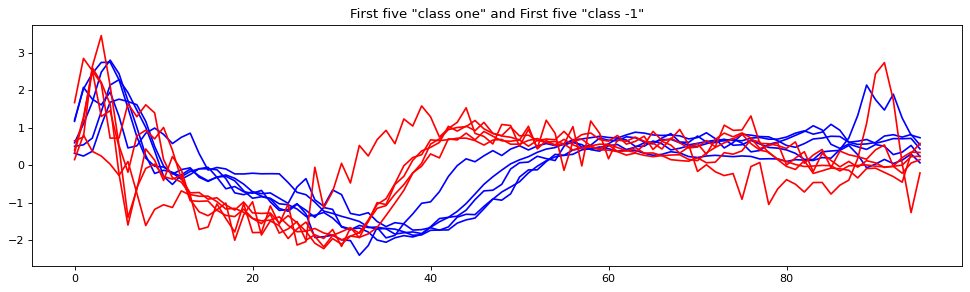

In [17]:
from matplotlib.pyplot import figure

figure(figsize=(15, 4), dpi=80)
plt.title('First five "class one" and First five "class -1"')
plt.plot(class1_train[0],  color="blue")
plt.plot(class1_train[1],  color="blue")
plt.plot(class1_train[2],  color="blue")
plt.plot(class1_train[3],  color="blue")
plt.plot(class1_train[4],  color="blue")

plt.plot(class2_train[0],  color="red")
plt.plot(class2_train[1],  color="red")
plt.plot(class2_train[2],  color="red")
plt.plot(class2_train[3],  color="red")
plt.plot(class2_train[4],  color="red")

plt.plot()

# Model Helper functions

### Function for Loss and Accuracy ploting curves

In [54]:
from IPython.core.pylabtools import figsize
def train_test_curves(history):
  import matplotlib as mpl
  mpl.rcParams.update(mpl.rcParamsDefault)

  history_dict = history.history
  loss_train_epochs = history_dict['loss']
  loss_val_epochs = history_dict['val_loss']

  fig,axs = plt.subplots(1,2,figsize=(15,3))

  axs[0].plot(loss_train_epochs,color='blue',label='train_loss')
  axs[0].plot(loss_val_epochs,color='red',label='val_loss')
  axs[0].set_xlabel('epoch')
  axs[0].set_ylabel('loss')
  axs[0].legend()
  

  history_dict = history.history
  loss_train_epochs = history_dict['accuracy']
  loss_val_epochs = history_dict['val_accuracy']

  axs[1].plot(loss_train_epochs,color='blue',label='train_accuracy')
  axs[1].plot(loss_val_epochs,color='red',label='val_accuracy')
  axs[1].set_xlabel('epoch')
  axs[1].set_ylabel('accuracy')
  axs[1].legend()
  

### Model Robustness Check Function

In [55]:
def ModelRobustnessCheck(Robust_model,x_train,y_train,showPlots=False,nb_epochs = 1000,percentage_of_train_as_validation = 0.3,mini_batch_size = 64):
  accuracy_list=[]
  val_accuracy_list=[]
  loss_list=[]
  val_loss_list=[]

  test_loss = []
  test_acc = []

  hist_dict={}
  checkpoint_filepath = '/tmp/checkpoint'
  model_checkpoint = keras.callbacks.ModelCheckpoint(filepath = '/tmp/checkpoint', monitor='val_accuracy', save_best_only=True, save_weights_only=True)
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=50,min_lr=0.01)

  for x in range(5):
      print("number of model ",x)
      tf.keras.backend.clear_session()
      Robust_model.compile(loss=cost_function,optimizer=optimizer_algo, metrics=['accuracy'])
      history = Robust_model.fit(x_train,y_train,verbose=False, batch_size=mini_batch_size, validation_split=percentage_of_train_as_validation ,epochs=nb_epochs,callbacks=[reduce_lr,model_checkpoint])
      history_dict = history.history
      histdict={f"hist #{x}":history}
      accuracy_list.append(history_dict['accuracy'])
      val_accuracy_list.append(history_dict['val_accuracy'])
      loss_list.append(history_dict['loss'])
      val_loss_list.append(history_dict['val_loss'])
      if showPlots:
        train_test_curves(history)
      loss,acc = Robust_model.evaluate(x_test,y_test,verbose=False)
      test_loss.append(loss)
      test_acc.append(acc)
      
      

  accuracy_std=np.std(accuracy_list)
  val_accuracy_std=np.std(val_accuracy_list)
  loss_std=np.std(loss_list)
  val_loss_std=np.std(val_loss_list)
  return accuracy_list, val_accuracy_list, loss_list, val_loss_list,test_loss,test_acc

# Model CNN

### Model 1 CNN 1D 3 Convolution layers

In [20]:
def CNNmodel1(input_shape):
    # input layer
    input_layer = keras.layers.Input(input_shape)

    # convolution layer
    conv_1 = keras.layers.Conv1D(filters=32, kernel_size=(8),padding='same')(input_layer)
    conv_1 = keras.layers.BatchNormalization()(conv_1)
    conv_1 = keras.layers.Activation(keras.activations.relu)(conv_1)

    # convolution layer
    conv_2 = keras.layers.Conv1D(filters=16, kernel_size=(5),padding='same')(conv_1)
    conv_2 = keras.layers.BatchNormalization()(conv_2)
    conv_2 = keras.layers.Activation(keras.activations.relu)(conv_2)

    # convolution layer
    conv_3 = keras.layers.Conv1D(filters=16, kernel_size=(3),padding='same')(conv_2) 
    conv_3 = keras.layers.BatchNormalization()(conv_3)
    conv_3 = keras.layers.Activation(keras.activations.relu)(conv_3)

    # Global average pooling
    gap = keras.layers.GlobalAveragePooling1D()(conv_3)

    # number of classes
    nb_classes = y_train.shape[1]

    # output 
    output_layer = keras.layers.Dense(units=nb_classes,activation='softmax')(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [21]:
CNNmodel1(x_train.shape[1:]).summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 96, 32)            288       
                                                                 
 batch_normalization (BatchN  (None, 96, 32)           128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 96, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 16)            2576      
                                                                 
 batch_normalization_1 (Batc  (None, 96, 16)           64        
 hNormalization)                                             

In [22]:
# choose optimization algorithm
tf.keras.backend.clear_session()
CNNmodelN1 = CNNmodel1(input_shape=x_train.shape[1:])

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath = '/tmp/checkpoint', monitor='val_accuracy', save_best_only=True, save_weights_only=True)

optimizer_algo = keras.optimizers.Adam()
cost_function = keras.losses.categorical_crossentropy

# compile model
CNNmodelN1.compile(loss=cost_function,optimizer=optimizer_algo, metrics=['accuracy'])
keras.backend.clear_session()
historyCNN1 = CNNmodelN1.fit(x_train,y_train,epochs=500,batch_size=30, validation_split=0.3, verbose = True, callbacks=[model_checkpoint]) # callbacks=[reduce_lr,eStop]
CNNmodelN1.load_weights(checkpoint_filepath)
loss,acc = CNNmodelN1.evaluate(x_test,y_test,verbose=False)

Epoch 1/500
3/3 [==============================] - 14s 482ms/step - loss: 0.5964 - accuracy: 0.7000 - val_loss: 0.6870 - val_accuracy: 0.6667
Epoch 2/500
3/3 [==============================] - 0s 37ms/step - loss: 0.5745 - accuracy: 0.7000 - val_loss: 0.6864 - val_accuracy: 0.6667
Epoch 3/500
3/3 [==============================] - 0s 45ms/step - loss: 0.5585 - accuracy: 0.7000 - val_loss: 0.6856 - val_accuracy: 0.6667
Epoch 4/500
3/3 [==============================] - 0s 50ms/step - loss: 0.5430 - accuracy: 0.7000 - val_loss: 0.6847 - val_accuracy: 0.6667
Epoch 5/500
3/3 [==============================] - 0s 42ms/step - loss: 0.5322 - accuracy: 0.7000 - val_loss: 0.6841 - val_accuracy: 0.6667
Epoch 6/500
3/3 [==============================] - 0s 101ms/step - loss: 0.5215 - accuracy: 0.7000 - val_loss: 0.6837 - val_accuracy: 0.7333
Epoch 7/500
3/3 [==============================] - 0s 92ms/step - loss: 0.5135 - accuracy: 0.7143 - val_loss: 0.6835 - val_accuracy: 0.7667
Epoch 8/500
3/3 [

In [23]:
CNNmodelN1.save("CNNmodelN1.h5")

print("Accuracy on the test set is:",acc)
print("Loss on the test set is:",loss)

Accuracy on the test set is: 0.8700000047683716
Loss on the test set is: 0.34701007604599


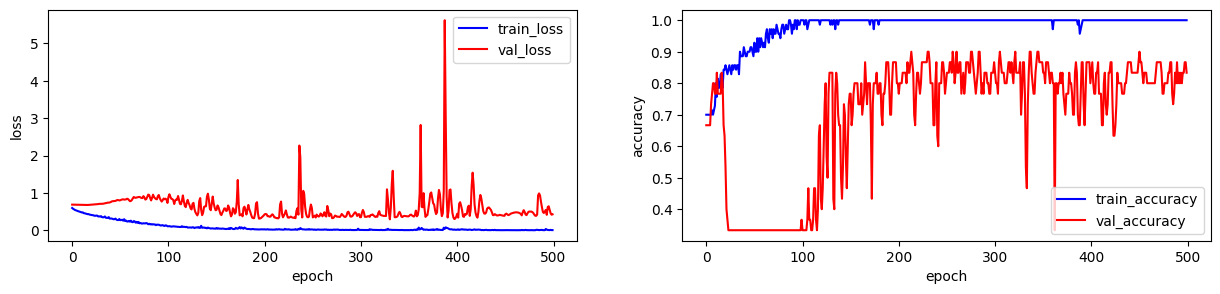

In [24]:
train_test_curves(historyCNN1)

### CNN1D Model with 2 Conv layer and 2 Dense

In [25]:
def CNNmodelTest(input_shape):
    # input layer
    input_layer = keras.layers.Input(input_shape)

    # convolution layer
    conv_2 = keras.layers.Conv1D(filters=16, kernel_size=(5),padding='same')(input_layer)
    conv_2 = keras.layers.BatchNormalization()(conv_2)
    conv_2 = keras.layers.Activation(keras.activations.relu)(conv_2)

    # convolution layer
    conv_3 = keras.layers.Conv1D(filters=16, kernel_size=(3),padding='same')(conv_2) 
    conv_3 = keras.layers.BatchNormalization()(conv_3)
    conv_3 = keras.layers.Activation(keras.activations.relu)(conv_3)

    # Global average pooling
    gap = keras.layers.GlobalAveragePooling1D()(conv_3)

    # number of classes
    nb_classes = y_train.shape[1]

    dense1 = keras.layers.Dense(units=6,activation='relu')(gap)

    # output 
    output_layer = keras.layers.Dense(units=nb_classes,activation='softmax')(dense1)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [26]:
# choose optimization algorithm
tf.keras.backend.clear_session()
CNNmodeltest = CNNmodelTest(input_shape=x_train.shape[1:])

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath = '/tmp/checkpoint', monitor='val_accuracy', save_best_only=True, save_weights_only=True)

optimizer_algo = keras.optimizers.Adam()
cost_function = keras.losses.categorical_crossentropy

# compile model
CNNmodeltest.compile(loss=cost_function,optimizer=optimizer_algo, metrics=['accuracy'])
keras.backend.clear_session()
historyCNN2 = CNNmodeltest.fit(x_train,y_train,epochs=500,batch_size=30, validation_split=0.3, verbose = True, callbacks=[model_checkpoint]) # callbacks=[reduce_lr,eStop]
CNNmodeltest.load_weights(checkpoint_filepath)
loss,acc = CNNmodeltest.evaluate(x_test,y_test,verbose=False)

Epoch 1/500
3/3 [==============================] - 1s 146ms/step - loss: 0.7133 - accuracy: 0.3000 - val_loss: 0.6949 - val_accuracy: 0.3333
Epoch 2/500
3/3 [==============================] - 0s 18ms/step - loss: 0.7060 - accuracy: 0.3000 - val_loss: 0.6946 - val_accuracy: 0.3333
Epoch 3/500
3/3 [==============================] - 0s 26ms/step - loss: 0.6989 - accuracy: 0.3000 - val_loss: 0.6940 - val_accuracy: 0.3333
Epoch 4/500
3/3 [==============================] - 0s 34ms/step - loss: 0.6930 - accuracy: 0.4857 - val_loss: 0.6933 - val_accuracy: 0.4333
Epoch 5/500
3/3 [==============================] - 0s 32ms/step - loss: 0.6888 - accuracy: 0.6857 - val_loss: 0.6927 - val_accuracy: 0.5667
Epoch 6/500
3/3 [==============================] - 0s 40ms/step - loss: 0.6843 - accuracy: 0.7429 - val_loss: 0.6920 - val_accuracy: 0.6667
Epoch 7/500
3/3 [==============================] - 0s 17ms/step - loss: 0.6804 - accuracy: 0.7286 - val_loss: 0.6913 - val_accuracy: 0.6667
Epoch 8/500
3/3 [==

In [27]:
print("Accuracy on the test set is:",acc)
print("Loss on the test set is:",loss)

Accuracy on the test set is: 0.7699999809265137
Loss on the test set is: 0.47091639041900635


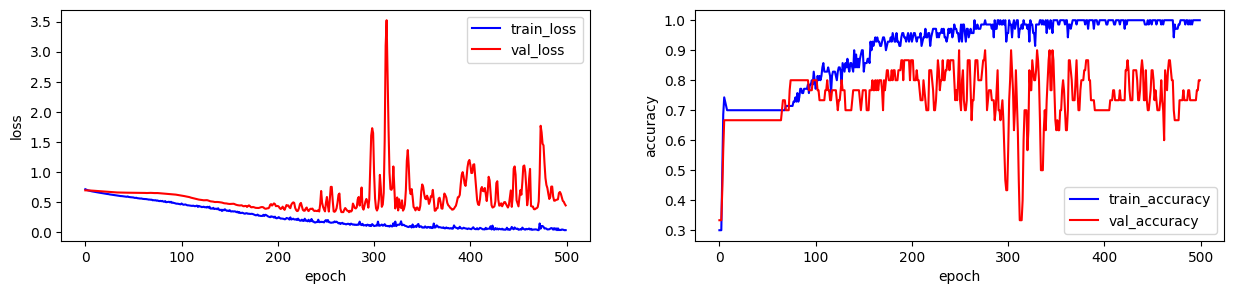

In [28]:
train_test_curves(historyCNN2)

### CNN1D Model with 2 Conv layer

In [29]:
def CNNmodel3(input_shape):
    # input layer
    input_layer = keras.layers.Input(input_shape)

    # convolution layer
    conv_1 = keras.layers.Conv1D(filters=64, kernel_size=(8),padding='same')(input_layer)
    conv_1 = keras.layers.BatchNormalization()(conv_1)
    conv_1 = keras.layers.Activation(keras.activations.relu)(conv_1)

    # convolution layer
    conv_2 = keras.layers.Conv1D(filters=32, kernel_size=(5),padding='same')(conv_1)
    conv_2 = keras.layers.BatchNormalization()(conv_2)
    conv_2 = keras.layers.Activation(keras.activations.relu)(conv_2)

    # Global average pooling
    gap = keras.layers.GlobalAveragePooling1D()(conv_2)

    # number of classes
    nb_classes = y_train.shape[1]

    # output 
    output_layer = keras.layers.Dense(units=nb_classes,activation='softmax')(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [30]:
# choose optimization algorithm
tf.keras.backend.clear_session()
CNNmodel3 = CNNmodel3(input_shape=x_train.shape[1:])

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath = '/tmp/checkpoint', monitor='val_accuracy', save_best_only=True, save_weights_only=True)

optimizer_algo = keras.optimizers.Adam()
cost_function = keras.losses.categorical_crossentropy

# compile model
CNNmodel3.compile(loss=cost_function,optimizer=optimizer_algo, metrics=['accuracy'])
keras.backend.clear_session()
historyCNN3 = CNNmodel3.fit(x_train,y_train,epochs=500,batch_size=30, validation_split=0.3, verbose = True, callbacks=[model_checkpoint]) # callbacks=[reduce_lr,eStop]
CNNmodel3.load_weights(checkpoint_filepath)
loss,acc = CNNmodel3.evaluate(x_test,y_test,verbose=False)

Epoch 1/500
3/3 [==============================] - 2s 198ms/step - loss: 0.8242 - accuracy: 0.3000 - val_loss: 0.6897 - val_accuracy: 0.6667
Epoch 2/500
3/3 [==============================] - 0s 18ms/step - loss: 0.7144 - accuracy: 0.4714 - val_loss: 0.6847 - val_accuracy: 0.6667
Epoch 3/500
3/3 [==============================] - 0s 18ms/step - loss: 0.6611 - accuracy: 0.6857 - val_loss: 0.6818 - val_accuracy: 0.6667
Epoch 4/500
3/3 [==============================] - 0s 28ms/step - loss: 0.6211 - accuracy: 0.7857 - val_loss: 0.6776 - val_accuracy: 0.6667
Epoch 5/500
3/3 [==============================] - 0s 18ms/step - loss: 0.5895 - accuracy: 0.7714 - val_loss: 0.6723 - val_accuracy: 0.6667
Epoch 6/500
3/3 [==============================] - 0s 19ms/step - loss: 0.5691 - accuracy: 0.7857 - val_loss: 0.6694 - val_accuracy: 0.6667
Epoch 7/500
3/3 [==============================] - 0s 18ms/step - loss: 0.5513 - accuracy: 0.7571 - val_loss: 0.6690 - val_accuracy: 0.6667
Epoch 8/500
3/3 [==

In [31]:
print("Accuracy on the test set is:",acc)
print("Loss on the test set is:",loss)

Accuracy on the test set is: 0.8199999928474426
Loss on the test set is: 0.37860286235809326


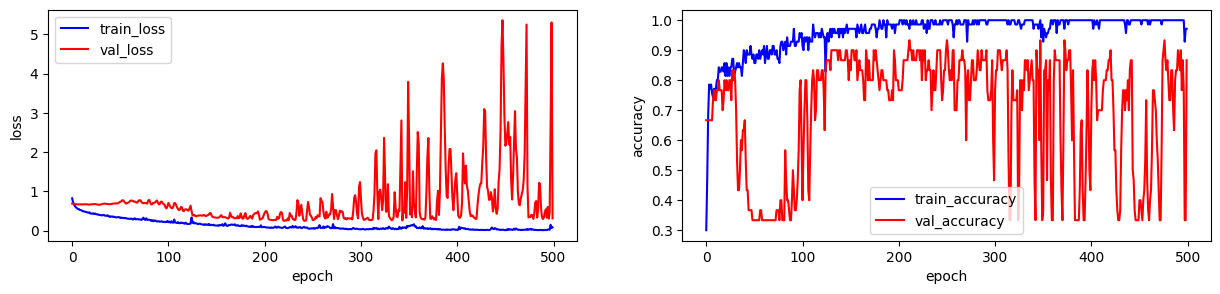

In [32]:
train_test_curves(historyCNN3)

## Model Regularization

We got best results on model 1 so we will use that model for regularization

In [63]:
def CNNREGmodel(input_shape):
    # input layer
    input_layer = keras.layers.Input(input_shape)

    # convolution layer
    conv_1 = keras.layers.Conv1D(filters=64, kernel_size=(8),padding='same', use_bias=True, kernel_regularizer =tf.keras.regularizers.l1( l=0.01))(input_layer)
    conv_1 = keras.layers.BatchNormalization()(conv_1)
    conv_1 = keras.layers.Activation(keras.activations.relu)(conv_1)
    conv_1  = keras.layers.Dropout(0.5)(conv_1)

    # convolution layer
    conv_2 = keras.layers.Conv1D(filters=32, kernel_size=(5),padding='same',use_bias=True,kernel_regularizer =tf.keras.regularizers.l1( l=0.01))(conv_1)
    conv_2 = keras.layers.BatchNormalization()(conv_2)
    conv_2 = keras.layers.Activation(keras.activations.relu)(conv_2)
    conv_2  = keras.layers.Dropout(0.5)(conv_2)

    # convolution layer
    conv_3 = keras.layers.Conv1D(filters=16, kernel_size=(3),padding='same',use_bias=True,kernel_regularizer =tf.keras.regularizers.l1( l=0.01))(conv_2) 
    conv_3 = keras.layers.BatchNormalization()(conv_3)
    conv_3 = keras.layers.Activation(keras.activations.relu)(conv_3)
    conv_3  = keras.layers.Dropout(0.5)(conv_3)

    # Global average pooling
    gap = keras.layers.GlobalAveragePooling1D()(conv_3)

    # number of classes
    nb_classes = y_train.shape[1]
    
    # output 
    output_layer = keras.layers.Dense(units=nb_classes,activation='softmax')(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

In [56]:
# choose optimization algorithm
tf.keras.backend.clear_session()
CNNREGmodel = CNNREGmodel(input_shape=x_train.shape[1:])

# Early Stopping
# eStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=50,min_lr=0.01)

checkpoint_filepath = '/tmp/checkpoint'

model_checkpoint = keras.callbacks.ModelCheckpoint(filepath = '/tmp/checkpoint', monitor='val_accuracy', save_best_only=True, save_weights_only=True)

# optimization method 
tf.keras.backend.clear_session()
optimizer_algo = keras.optimizers.Adam(learning_rate=0.001)
cost_function = keras.losses.categorical_crossentropy

# compile model
keras.backend.clear_session()
CNNREGmodel.compile(loss=cost_function,optimizer=optimizer_algo, metrics=['accuracy'])
historyCNN4 = CNNREGmodel.fit(x_train,y_train,epochs=500,batch_size=20, validation_split=0.3, verbose = True, callbacks=[model_checkpoint,reduce_lr]) #eStop
CNNREGmodel.load_weights(checkpoint_filepath)
loss,acc = CNNREGmodel.evaluate(x_test,y_test,verbose=False)

Epoch 1/500
4/4 [==============================] - 2s 117ms/step - loss: 8.2180 - accuracy: 0.3714 - val_loss: 7.8534 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/500
4/4 [==============================] - 0s 29ms/step - loss: 7.7830 - accuracy: 0.3429 - val_loss: 7.4284 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 3/500
4/4 [==============================] - 0s 18ms/step - loss: 7.3541 - accuracy: 0.3571 - val_loss: 7.0236 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 4/500
4/4 [==============================] - 0s 23ms/step - loss: 6.9324 - accuracy: 0.4714 - val_loss: 6.6377 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 5/500
4/4 [==============================] - 0s 19ms/step - loss: 6.5344 - accuracy: 0.4714 - val_loss: 6.2685 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 6/500
4/4 [==============================] - 0s 18ms/step - loss: 6.1474 - accuracy: 0.6286 - val_loss: 5.9155 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 7/500
4/4 [==============================] - 0s 18ms/step - loss: 5.7822 - 

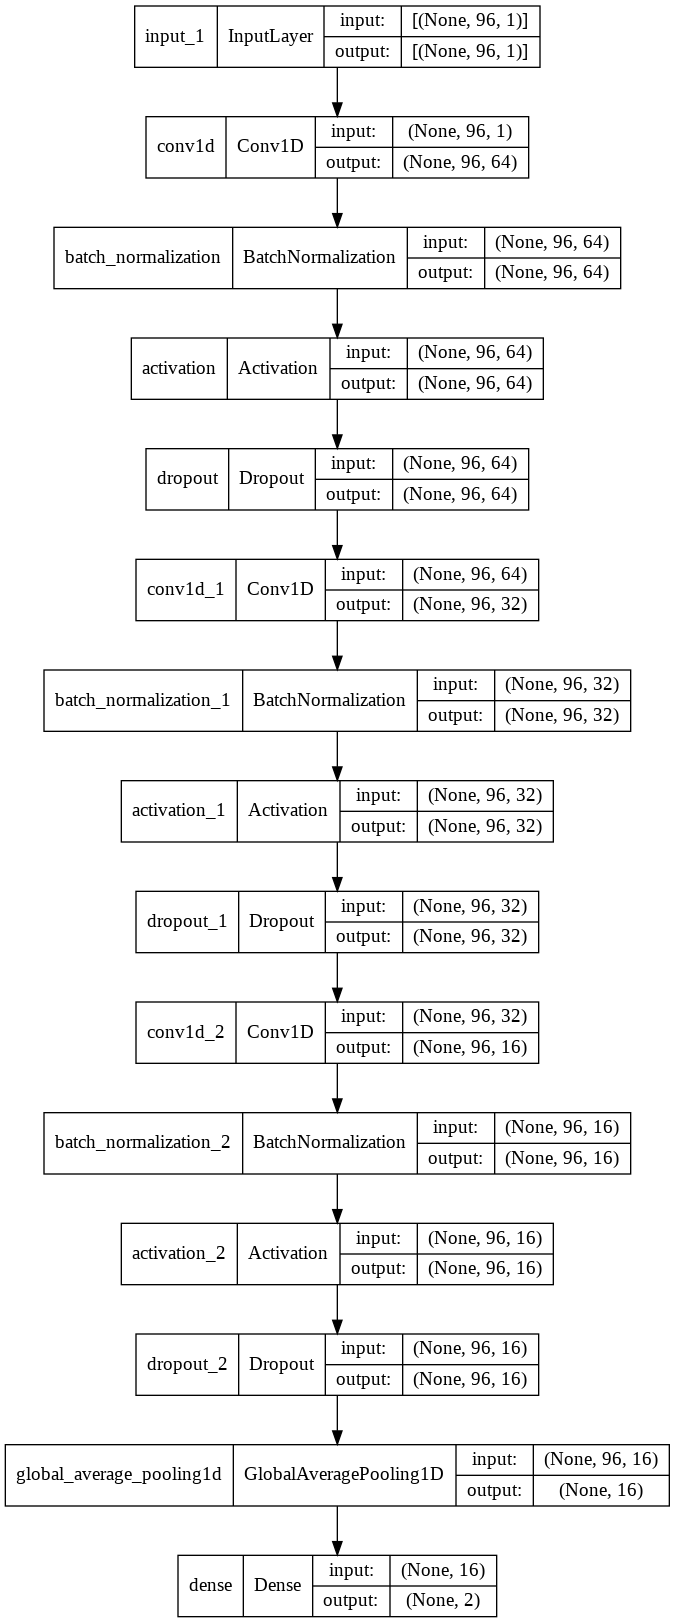

In [57]:
tf.keras.utils.plot_model(CNNREGmodel, to_file="yePCNN.png", show_shapes=True)


In [58]:
CNNREGmodel.save('BestModelCNN.h5')

In [62]:
CNNREGmodel.save("BestModel.h5")

print("Accuracy on the test set is:",acc)
print("Loss on the test set is:",loss)

Accuracy on the test set is: 0.8600000143051147
Loss on the test set is: 0.5681391358375549


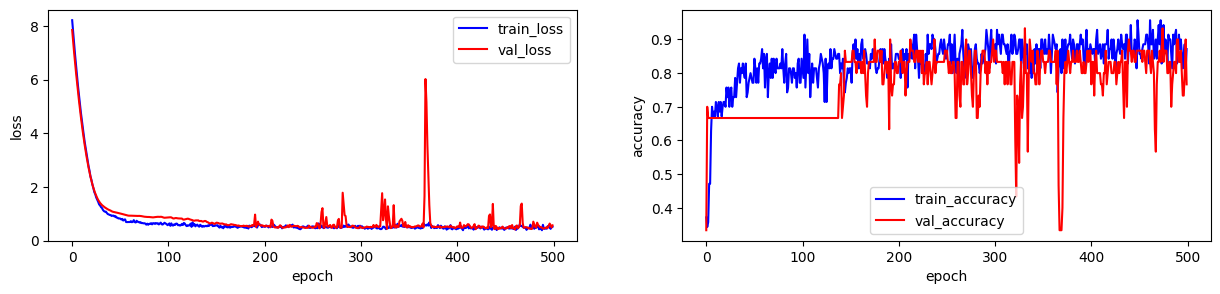

In [60]:
train_test_curves(historyCNN4)

## Summary Seleccting best model

### **Model Robustness Check**

In [43]:
CNNREGmodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 96, 64)            576       
                                                                 
 batch_normalization (BatchN  (None, 96, 64)           256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 96, 64)            0         
                                                                 
 dropout (Dropout)           (None, 96, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 32)            10272     
                                                             

number of model  0
number of model  1
number of model  2
number of model  3
number of model  4


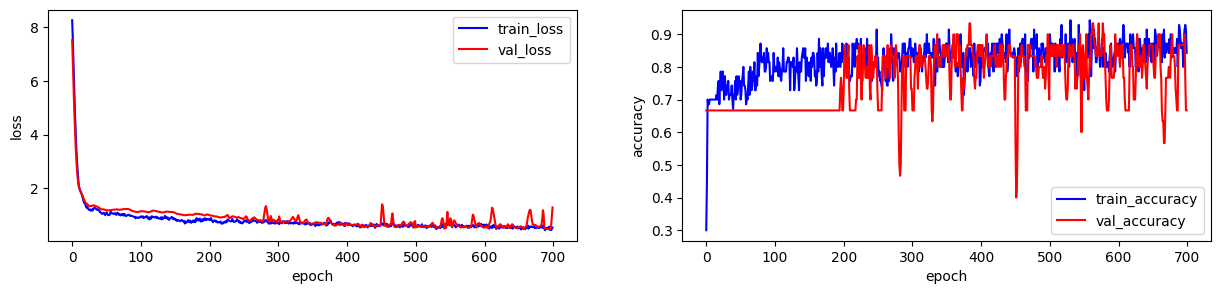

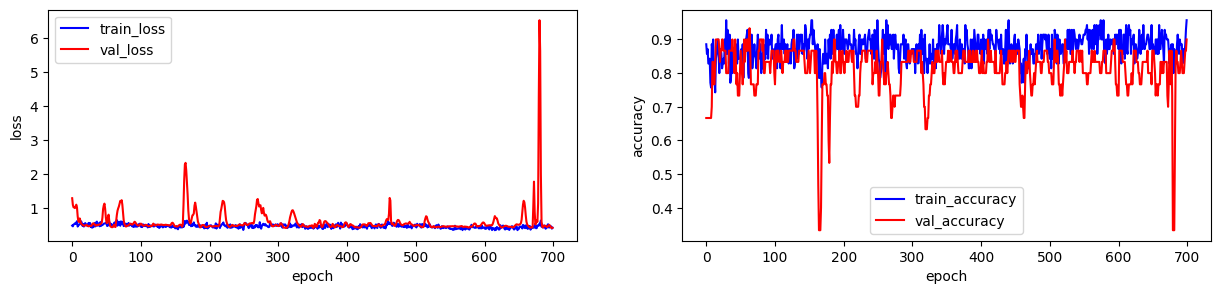

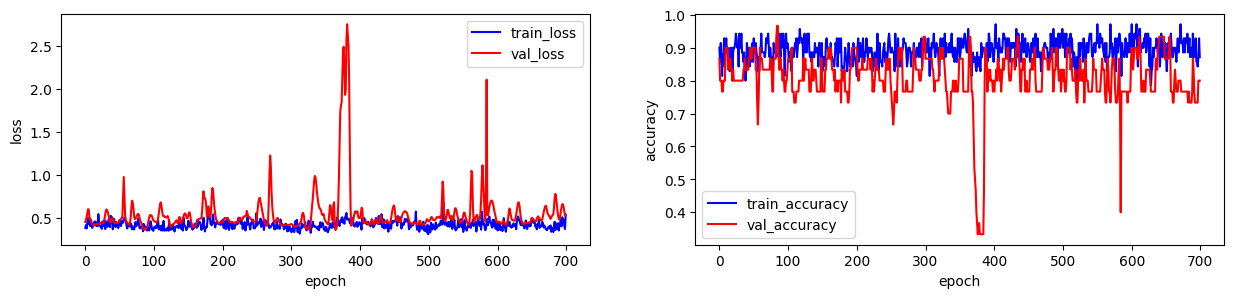

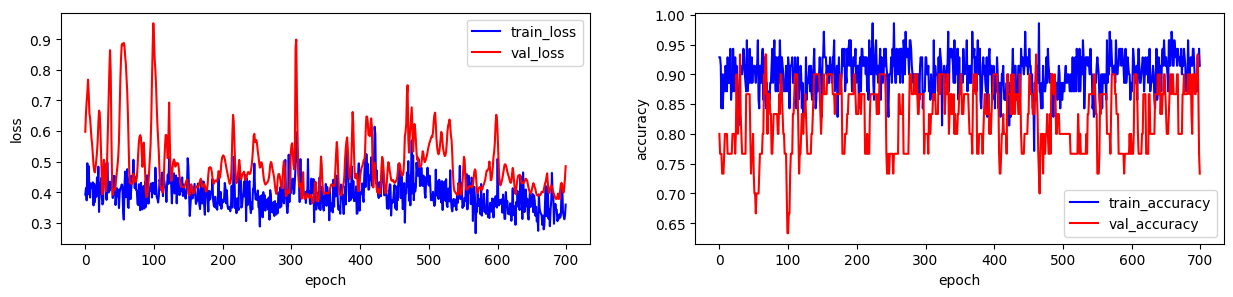

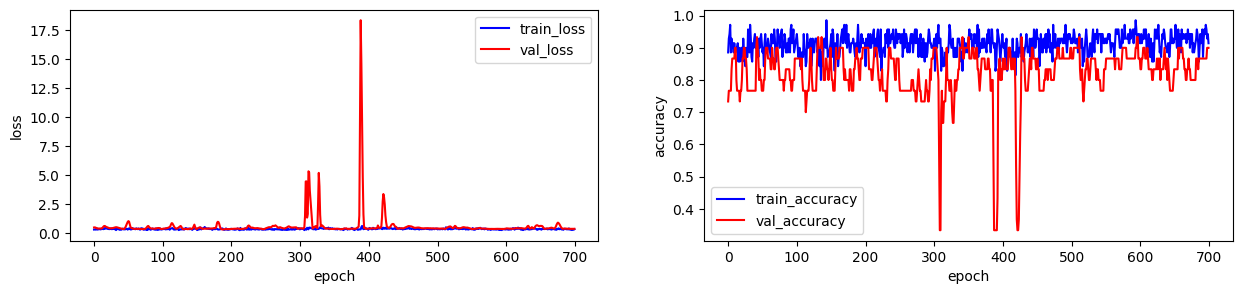

In [64]:
# we select CNNREGmodel as good model and we whant to test it's robustness
CNNREGmodel1 = CNNREGmodel(input_shape=x_train.shape[1:])


accuracy_list, val_accuracy_list, loss_list, val_loss_list,test_loss,test_acc = ModelRobustnessCheck(CNNREGmodel1,x_train,y_train,True,nb_epochs=700)


In [65]:
print("loss mean:",np.average(test_loss))
print("acc mean:",np.average(test_acc))

print("\nloss std:",np.std(test_loss))
print("acc std:",np.std(test_acc))

loss mean: 0.7593467473983765
acc mean: 0.777999997138977

loss std: 0.32410318600255894
acc std: 0.0696850099264134


# LSTM

## LSTM1

In [66]:
# tf.keras.utils.plot_model(LSTModel, to_file="LSTM.png", show_shapes=True)


In [67]:
def LSTMmodel(input_shape):
  tf.keras.backend.clear_session()
  nb_neurons = 24
  dropout_rate=0.5

  # input layer
  input_layer = keras.layers.Input(input_shape)

  # first hidden layer of an LSTM containing nb_neurons
  hidden_layer_1 = keras.layers.LSTM(units=nb_neurons)(input_layer)

  # Dropout
  dropout = keras.layers.Dropout(dropout_rate)(hidden_layer_1)

  # last linear prediction layer that predicts a single real value
  output_layer = keras.layers.Dense(units=2,activation="softmax")(dropout)

  return keras.models.Model(inputs=input_layer, outputs=output_layer)


In [68]:
LSTModel = LSTMmodel(input_shape=x_train.shape[1:])
# LSTModel.summary()
# cost function for regression
cost_function = keras.losses.categorical_crossentropy

# Early Stopping
eStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

# optimization method 
optimizer_algo = keras.optimizers.Adam(learning_rate=0.001)

checkpoint_filepath = '/tmp/checkpointLSTM'
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath, monitor='val_accuracy', save_best_only=True, save_weights_only=True)

# compilmodel
tf.keras.backend.clear_session()
LSTModel.compile(loss=cost_function, optimizer=optimizer_algo, metrics=['accuracy'])
nb_epoch = 500
batch_size = 20

historyLSTM1 = LSTModel.fit(x_train, y_train, epochs=nb_epoch, batch_size=batch_size, shuffle=False, validation_split=0.3,callbacks=[reduce_lr,model_checkpoint])
loss,acc = LSTModel.evaluate(x_test,y_test,verbose=False)

Epoch 1/500
4/4 [==============================] - 3s 305ms/step - loss: 0.7161 - accuracy: 0.4857 - val_loss: 0.6915 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 2/500
4/4 [==============================] - 0s 33ms/step - loss: 0.7074 - accuracy: 0.6429 - val_loss: 0.6833 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 3/500
4/4 [==============================] - 0s 30ms/step - loss: 0.6675 - accuracy: 0.7429 - val_loss: 0.6755 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 4/500
4/4 [==============================] - 0s 33ms/step - loss: 0.6736 - accuracy: 0.7000 - val_loss: 0.6675 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 5/500
4/4 [==============================] - 0s 28ms/step - loss: 0.6463 - accuracy: 0.8286 - val_loss: 0.6591 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 6/500
4/4 [==============================] - 0s 31ms/step - loss: 0.6466 - accuracy: 0.7429 - val_loss: 0.6500 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 7/500
4/4 [==============================] - 0s 33ms/step - loss: 0.6322 - 

In [69]:
print("Accuracy on the test set is:",acc)
print("Loss on the test set is:",loss)

Accuracy on the test set is: 0.8199999928474426
Loss on the test set is: 0.7450299263000488


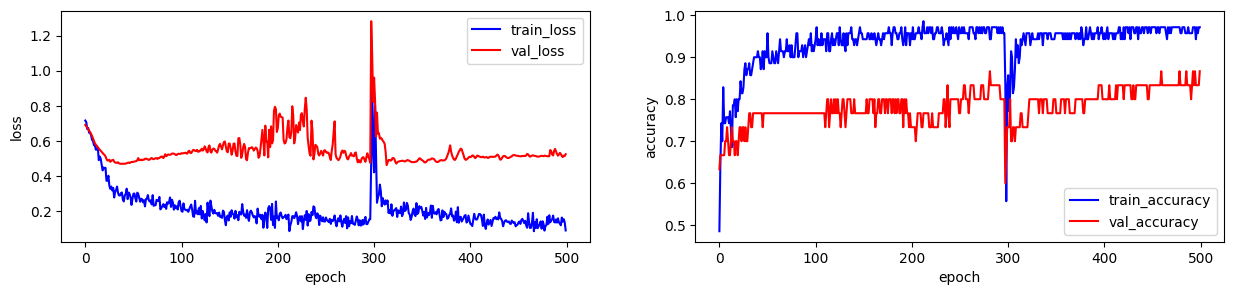

In [70]:
train_test_curves(historyLSTM1)

## Smaller LSTM 

In [71]:
def LSTMmodel2(input_shape):
  tf.keras.backend.clear_session()
  nb_neurons = 12
  dropout_rate=0.5

  # input layer
  input_layer = keras.layers.Input(input_shape)

  # first hidden layer of an LSTM containing nb_neurons
  hidden_layer_1 = keras.layers.LSTM(units=nb_neurons)(input_layer)

  # Dropout
  dropout = keras.layers.Dropout(dropout_rate)(hidden_layer_1)

  # last linear prediction layer that predicts a single real value
  output_layer = keras.layers.Dense(units=2,activation="softmax")(dropout)

  return keras.models.Model(inputs=input_layer, outputs=output_layer)


In [72]:
LSTMmodel2 = LSTMmodel2(input_shape=x_train.shape[1:])
# LSTModel.summary()
# cost function for regression
cost_function = keras.losses.categorical_crossentropy

# Early Stopping
eStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

# optimization method 
optimizer_algo = keras.optimizers.Adam(learning_rate=0.001)

checkpoint_filepath = '/tmp/checkpointLSTM'
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath, monitor='val_accuracy', save_best_only=True, save_weights_only=True)

# compilmodel
tf.keras.backend.clear_session()
LSTMmodel2.compile(loss=cost_function, optimizer=optimizer_algo, metrics=['accuracy'])
nb_epoch = 500
batch_size = 20

historyLSTM2 = LSTMmodel2.fit(x_train, y_train, epochs=nb_epoch, batch_size=batch_size, shuffle=False, validation_split=0.3,callbacks=[reduce_lr,model_checkpoint])

loss,acc = LSTMmodel2.evaluate(x_test,y_test,verbose=False)

Epoch 1/500
4/4 [==============================] - 3s 209ms/step - loss: 0.6723 - accuracy: 0.5571 - val_loss: 0.6757 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 2/500
4/4 [==============================] - 0s 27ms/step - loss: 0.6613 - accuracy: 0.7143 - val_loss: 0.6688 - val_accuracy: 0.6333 - lr: 0.0010
Epoch 3/500
4/4 [==============================] - 0s 29ms/step - loss: 0.6469 - accuracy: 0.7429 - val_loss: 0.6619 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 4/500
4/4 [==============================] - 0s 33ms/step - loss: 0.6441 - accuracy: 0.7143 - val_loss: 0.6550 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 5/500
4/4 [==============================] - 0s 32ms/step - loss: 0.6190 - accuracy: 0.8429 - val_loss: 0.6478 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 6/500
4/4 [==============================] - 0s 35ms/step - loss: 0.6123 - accuracy: 0.8143 - val_loss: 0.6403 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 7/500
4/4 [==============================] - 0s 27ms/step - loss: 0.6139 - 

In [73]:
print("Accuracy on the test set is:",acc)
print("Loss on the test set is:",loss)

Accuracy on the test set is: 0.7300000190734863
Loss on the test set is: 0.8500792980194092


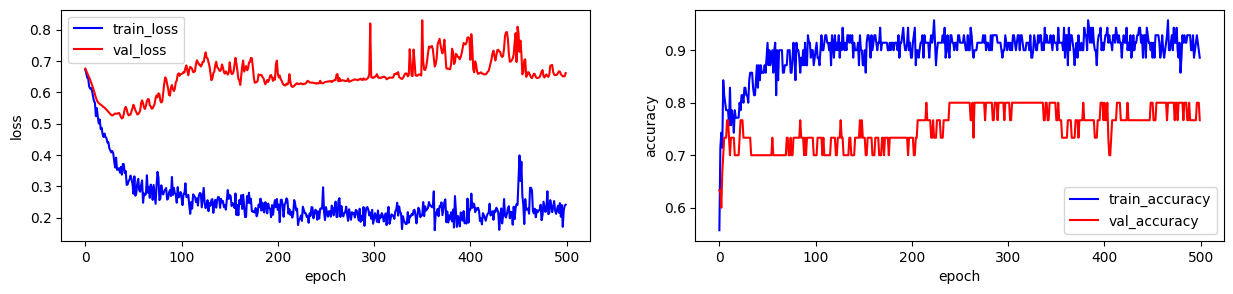

In [74]:
train_test_curves(historyLSTM2)

## BIG LSTM

In [75]:
def BIGLSTM(input_shape, nb_neurons = 256,dropout_rate=0.5):
  tf.keras.backend.clear_session()
  nb_neurons = 256
  dropout_rate=0.5

  # input layer
  input_layer = keras.layers.Input(input_shape)

  # first hidden layer of an LSTM containing nb_neurons
  hidden_layer_1 = keras.layers.LSTM(units=nb_neurons)(input_layer)

  # Dropout
  dropout = keras.layers.Dropout(dropout_rate)(hidden_layer_1)

  # last linear prediction layer that predicts a single real value
  output_layer = keras.layers.Dense(units=2,activation="softmax")(dropout)

  return keras.models.Model(inputs=input_layer, outputs=output_layer)


In [76]:
BIGLSTMModel = BIGLSTM(input_shape=x_train.shape[1:])
# LSTModel.summary()
# cost function for regression
cost_function = keras.losses.categorical_crossentropy

# Early Stopping
eStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

# optimization method 
optimizer_algo = keras.optimizers.Adam(learning_rate=0.001)

checkpoint_filepath = '/tmp/checkpointLSTM'
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath, monitor='val_accuracy', save_best_only=True, save_weights_only=True)

# compilmodel
tf.keras.backend.clear_session()
BIGLSTMModel.compile(loss=cost_function, optimizer=optimizer_algo, metrics=['accuracy'])
nb_epoch = 500
batch_size = 20

historyLSTM3 = BIGLSTMModel.fit(x_train, y_train, epochs=nb_epoch, batch_size=batch_size, shuffle=False, validation_split=0.3,callbacks=[reduce_lr,model_checkpoint])

loss,acc = BIGLSTMModel.evaluate(x_test,y_test,verbose=False)

Epoch 1/500
4/4 [==============================] - 3s 240ms/step - loss: 0.6691 - accuracy: 0.6143 - val_loss: 0.6633 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 2/500
4/4 [==============================] - 0s 59ms/step - loss: 0.6302 - accuracy: 0.7857 - val_loss: 0.6206 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 3/500
4/4 [==============================] - 0s 51ms/step - loss: 0.5364 - accuracy: 0.7286 - val_loss: 0.6375 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 4/500
4/4 [==============================] - 0s 52ms/step - loss: 0.4728 - accuracy: 0.7429 - val_loss: 0.5462 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 5/500
4/4 [==============================] - 0s 52ms/step - loss: 0.4498 - accuracy: 0.7571 - val_loss: 0.5131 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 6/500
4/4 [==============================] - 0s 52ms/step - loss: 0.3979 - accuracy: 0.8143 - val_loss: 0.7643 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 7/500
4/4 [==============================] - 0s 64ms/step - loss: 0.5356 - 

In [77]:
print("Accuracy on the test set is:",acc)
print("Loss on the test set is:",loss)

Accuracy on the test set is: 0.8199999928474426
Loss on the test set is: 1.4524755477905273


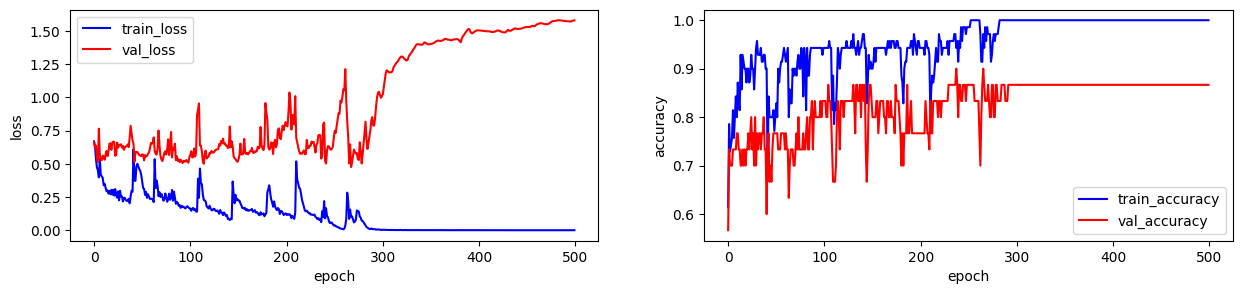

In [78]:
train_test_curves(historyLSTM3)

## GRU

In [79]:
def GRUmodel(input_shape):
  tf.keras.backend.clear_session()
  nb_neurons = 24
  dropout_rate=0.5

  # input layer
  input_layer = keras.layers.Input(input_shape)

  # first hidden layer of an LSTM containing nb_neurons
  hidden_layer_1 = keras.layers.GRU(units=nb_neurons)(input_layer)

  # Dropout
  dropout = keras.layers.Dropout(dropout_rate)(hidden_layer_1)

  # last linear prediction layer that predicts a single real value
  output_layer = keras.layers.Dense(units=2,activation="softmax")(dropout)

  return keras.models.Model(inputs=input_layer, outputs=output_layer)


In [80]:
GRUmodel = GRUmodel(input_shape=x_train.shape[1:])
# LSTModel.summary()
# cost function for regression
cost_function = keras.losses.categorical_crossentropy

# Early Stopping
eStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

# optimization method 
optimizer_algo = keras.optimizers.Adam(learning_rate=0.001)

checkpoint_filepath = '/tmp/checkpointLSTM'
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath, monitor='val_accuracy', save_best_only=True, save_weights_only=True)

# compilmodel
tf.keras.backend.clear_session()
GRUmodel.compile(loss=cost_function, optimizer=optimizer_algo, metrics=['accuracy'])
nb_epoch = 500
batch_size = 256

historyGRU = GRUmodel.fit(x_train, y_train, epochs=nb_epoch, batch_size=batch_size, shuffle=False, validation_split=0.3,callbacks=[reduce_lr,model_checkpoint])

loss,acc = GRUmodel.evaluate(x_test,y_test,verbose=False)

Epoch 1/500
1/1 [==============================] - 2s 2s/step - loss: 0.7017 - accuracy: 0.4857 - val_loss: 0.6918 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 2/500
1/1 [==============================] - 0s 50ms/step - loss: 0.6860 - accuracy: 0.5857 - val_loss: 0.6889 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 3/500
1/1 [==============================] - 0s 50ms/step - loss: 0.6841 - accuracy: 0.5714 - val_loss: 0.6861 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 4/500
1/1 [==============================] - 0s 48ms/step - loss: 0.6676 - accuracy: 0.6429 - val_loss: 0.6833 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 5/500
1/1 [==============================] - 0s 65ms/step - loss: 0.6647 - accuracy: 0.6286 - val_loss: 0.6806 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 6/500
1/1 [==============================] - 0s 63ms/step - loss: 0.6923 - accuracy: 0.6143 - val_loss: 0.6779 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 7/500
1/1 [==============================] - 0s 49ms/step - loss: 0.6720 - acc

In [81]:
print("Accuracy on the test set is:",acc)
print("Loss on the test set is:",loss)

Accuracy on the test set is: 0.7599999904632568
Loss on the test set is: 0.9538307189941406


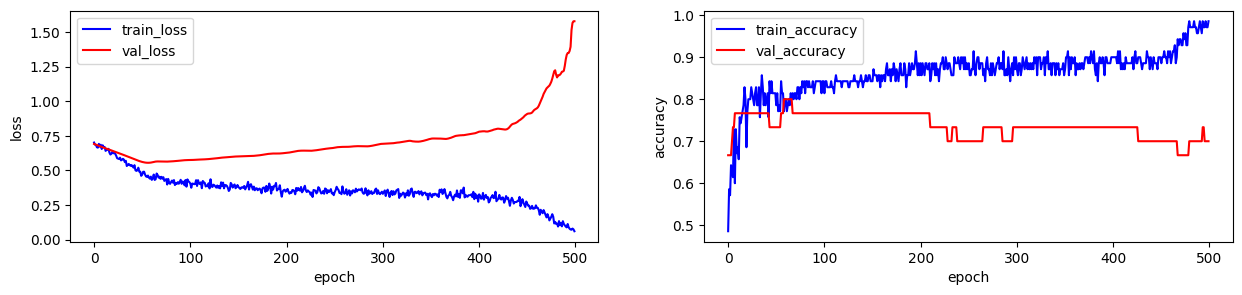

In [82]:
train_test_curves(historyGRU)

## **Robustness of the evaluation**

number of model  0
number of model  1
number of model  2
number of model  3
number of model  4


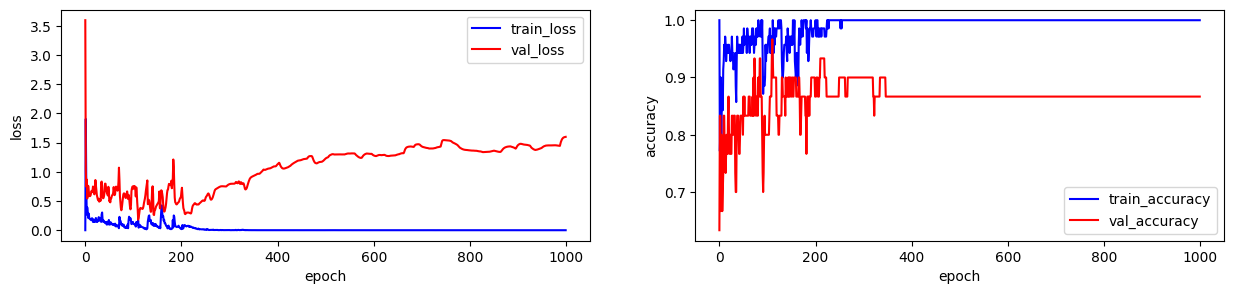

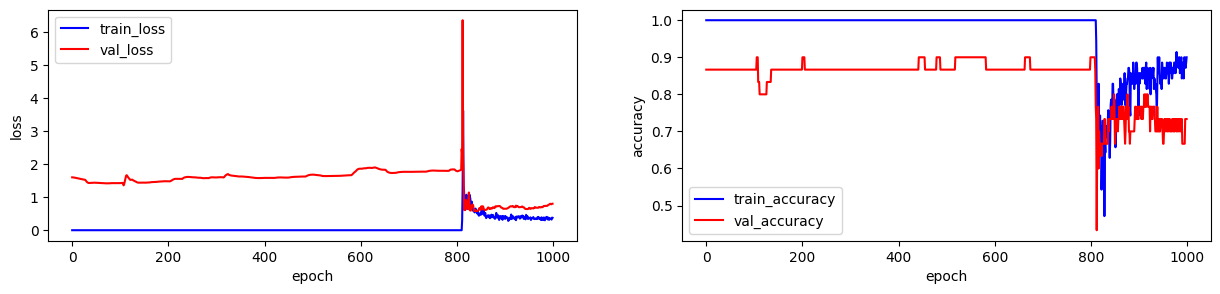

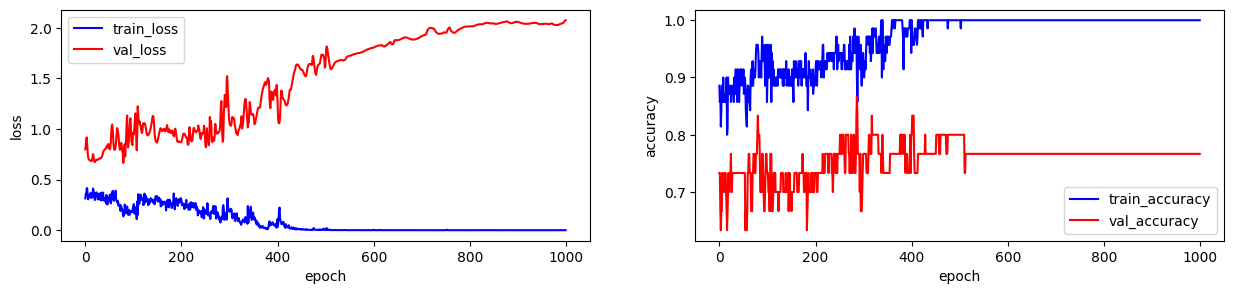

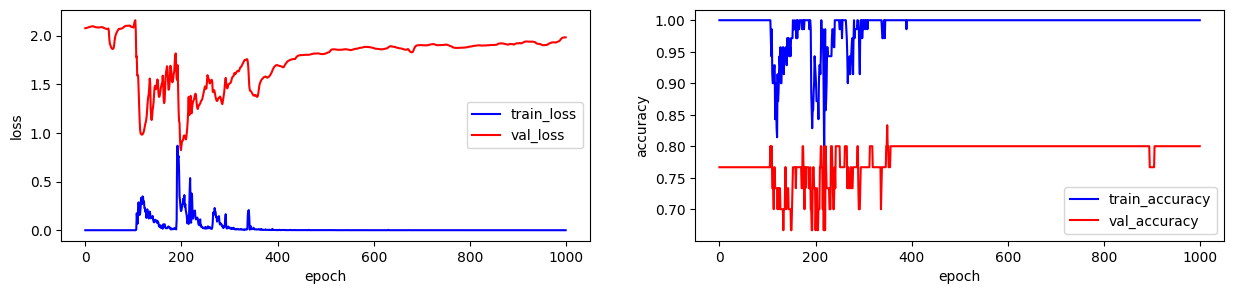

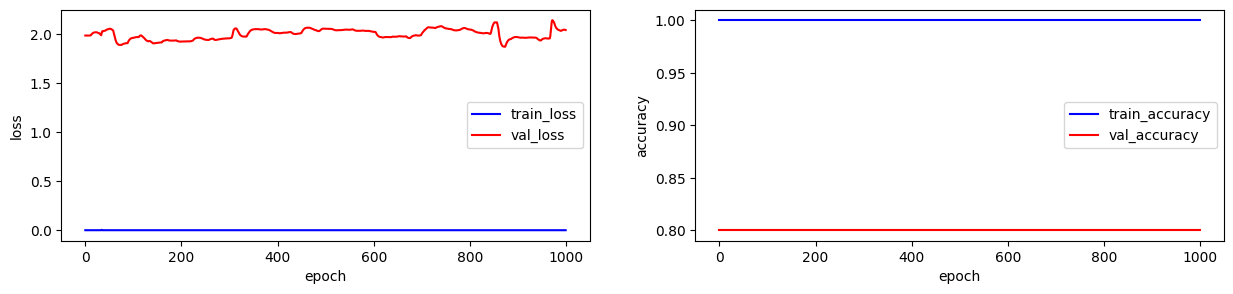

In [105]:
# We have selected and measuring the models robustness with training model 5 times

accuracy_list, val_accuracy_list, loss_list, val_loss_list,test_loss,test_acc = ModelRobustnessCheck(BIGLSTMModel,x_train,y_train,True)

In [106]:
print("loss mean:",np.average(test_loss))
print("acc mean:",np.average(test_acc))

print("\nloss std:",np.std(test_loss))
print("acc std:",np.std(test_acc))

loss mean: 1.8107107162475586
acc mean: 0.7579999923706054

loss std: 0.5427456412580394
acc std: 0.04261454723092254


# Inbalanced Data

In [85]:
train_Inb = np.genfromtxt(fname="ECG200_TRAIN.tsv", delimiter="\t", filling_values=1)  # change filling_values as req'd to fill in missing values
test_Inb = np.genfromtxt(fname="ECG200_TEST.tsv", delimiter="\t", filling_values=1)  # change filling_values as req'd to fill in missing values

In [86]:
class1_train_Inb = train_Inb[y_train[:,0]==1]
class2_train_Inb = train_Inb[y_train[:,0]==0]
class1_test_Inb = test_Inb[y_test[:,0]==1]
class2_test_Inb = test_Inb[y_test[:,0]==0]

In [87]:
class1_train_Inb.shape

(31, 97)

## Downsampling

In [88]:
class2_train_Inb = class2_train_Inb[:class1_train_Inb.shape[0]]
class2_test_Inb = class2_test_Inb[:class1_test_Inb.shape[0]]

In [89]:
print(class1_train_Inb.shape, class2_train_Inb.shape, class1_test_Inb.shape, class2_test_Inb.shape)

(31, 97) (31, 97) (36, 97) (36, 97)


In [90]:
b_train = np.concatenate([class1_train_Inb,class2_train_Inb],0)
b_test = np.concatenate([class1_test_Inb,class2_test_Inb],0)
print(b_train.shape,b_test.shape)

(62, 97) (72, 97)


In [91]:
np.random.shuffle(b_train)
np.random.shuffle(b_test)

In [92]:
x_train_b,y_train_b,x_test_b,y_test_b = SplitXY(b_train,b_test)

y_train (62,)
y_test (72,)
new_y_train (62, 2)
new_y_test (72, 2)


In [93]:
x_train_b.shape

(62, 96, 1)

## Using this balanced data on Model

In [94]:
Balanced_LSTModel = LSTMmodel(input_shape=x_train_b.shape[1:])
# Balanced_LSTModel.summary()
# cost function for regression
cost_function = keras.losses.categorical_crossentropy

# Early Stopping
eStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

# optimization method 
optimizer_algo = keras.optimizers.Adam(learning_rate=0.001)

checkpoint_filepath = '/tmp/checkpointLSTM'
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath, monitor='val_accuracy', save_best_only=True, save_weights_only=True)

# compilmodel
tf.keras.backend.clear_session()
Balanced_LSTModel.compile(loss=cost_function, optimizer=optimizer_algo, metrics=['accuracy'])
nb_epoch = 500
batch_size = 20

hist_Balanced_LSTModel = Balanced_LSTModel.fit(x_train_b, y_train_b, epochs=nb_epoch, batch_size=batch_size, shuffle=False, validation_split=0.3,callbacks=[reduce_lr,model_checkpoint])
loss,acc = Balanced_LSTModel.evaluate(x_test,y_test,verbose=False)

Epoch 1/500
3/3 [==============================] - 3s 319ms/step - loss: 0.6877 - accuracy: 0.6047 - val_loss: 0.6840 - val_accuracy: 0.6842 - lr: 0.0010
Epoch 2/500
3/3 [==============================] - 0s 43ms/step - loss: 0.7022 - accuracy: 0.5349 - val_loss: 0.6773 - val_accuracy: 0.7368 - lr: 0.0010
Epoch 3/500
3/3 [==============================] - 0s 30ms/step - loss: 0.6963 - accuracy: 0.4651 - val_loss: 0.6721 - val_accuracy: 0.7368 - lr: 0.0010
Epoch 4/500
3/3 [==============================] - 0s 31ms/step - loss: 0.6758 - accuracy: 0.5814 - val_loss: 0.6675 - val_accuracy: 0.7368 - lr: 0.0010
Epoch 5/500
3/3 [==============================] - 0s 32ms/step - loss: 0.6726 - accuracy: 0.5814 - val_loss: 0.6633 - val_accuracy: 0.7368 - lr: 0.0010
Epoch 6/500
3/3 [==============================] - 0s 30ms/step - loss: 0.6878 - accuracy: 0.5349 - val_loss: 0.6591 - val_accuracy: 0.7368 - lr: 0.0010
Epoch 7/500
3/3 [==============================] - 0s 29ms/step - loss: 0.6755 - 

In [95]:
# CNNmodelN1.save("baseModel.h5")

print("Accuracy on the test set is:",acc)
print("Loss on the test set is:",loss)

Accuracy on the test set is: 0.7799999713897705
Loss on the test set is: 1.289708137512207


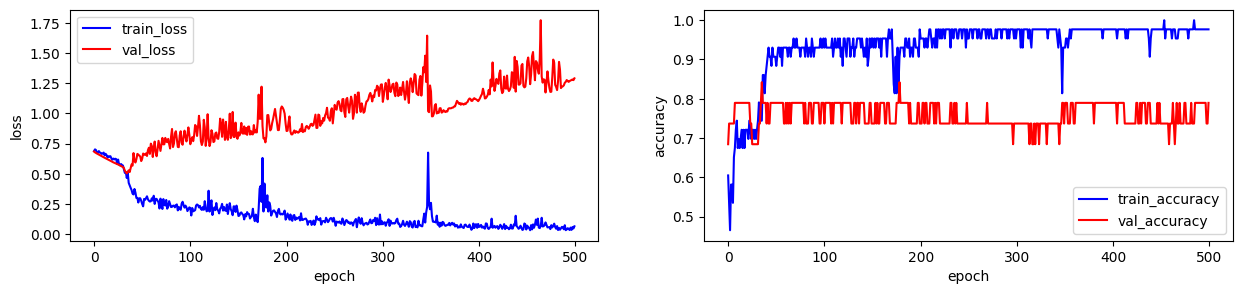

In [96]:
train_test_curves(hist_Balanced_LSTModel)

In [97]:
Balanced_CNNBest = CNNREGmodel(input_shape=x_train_b.shape[1:])
# Balanced_CNNBest.summary()
# cost function for regression
cost_function = keras.losses.categorical_crossentropy

# Early Stopping
eStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

# optimization method 
optimizer_algo = keras.optimizers.Adam(learning_rate=0.001)

checkpoint_filepath = '/tmp/checkpointLSTM'
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath, monitor='val_accuracy', save_best_only=True, save_weights_only=True)

# compilmodel
tf.keras.backend.clear_session()
Balanced_CNNBest.compile(loss=cost_function, optimizer=optimizer_algo, metrics=['accuracy'])
nb_epoch = 500
batch_size = 20

hist_Balanced_CNNBest = Balanced_CNNBest.fit(x_train_b, y_train_b, epochs=nb_epoch, batch_size=batch_size, shuffle=False, validation_split=0.3,callbacks=[reduce_lr,model_checkpoint])
loss,acc = Balanced_CNNBest.evaluate(x_test,y_test,verbose=False)

Epoch 1/500
3/3 [==============================] - 2s 314ms/step - loss: 8.1996 - accuracy: 0.5349 - val_loss: 7.9503 - val_accuracy: 0.4737 - lr: 0.0010
Epoch 2/500
3/3 [==============================] - 0s 22ms/step - loss: 7.8835 - accuracy: 0.4651 - val_loss: 7.6329 - val_accuracy: 0.4737 - lr: 0.0010
Epoch 3/500
3/3 [==============================] - 0s 20ms/step - loss: 7.5793 - accuracy: 0.5116 - val_loss: 7.3292 - val_accuracy: 0.4737 - lr: 0.0010
Epoch 4/500
3/3 [==============================] - 0s 21ms/step - loss: 7.2657 - accuracy: 0.5116 - val_loss: 7.0368 - val_accuracy: 0.4737 - lr: 0.0010
Epoch 5/500
3/3 [==============================] - 0s 37ms/step - loss: 6.9565 - accuracy: 0.6279 - val_loss: 6.7539 - val_accuracy: 0.5263 - lr: 0.0010
Epoch 6/500
3/3 [==============================] - 0s 21ms/step - loss: 6.6802 - accuracy: 0.6047 - val_loss: 6.4793 - val_accuracy: 0.4211 - lr: 0.0010
Epoch 7/500
3/3 [==============================] - 0s 21ms/step - loss: 6.4073 - 

In [98]:
# CNNmodelN1.save("baseModel.h5")

print("Accuracy on the test set is:",acc)
print("Loss on the test set is:",loss)

Accuracy on the test set is: 0.8399999737739563
Loss on the test set is: 0.7764442563056946


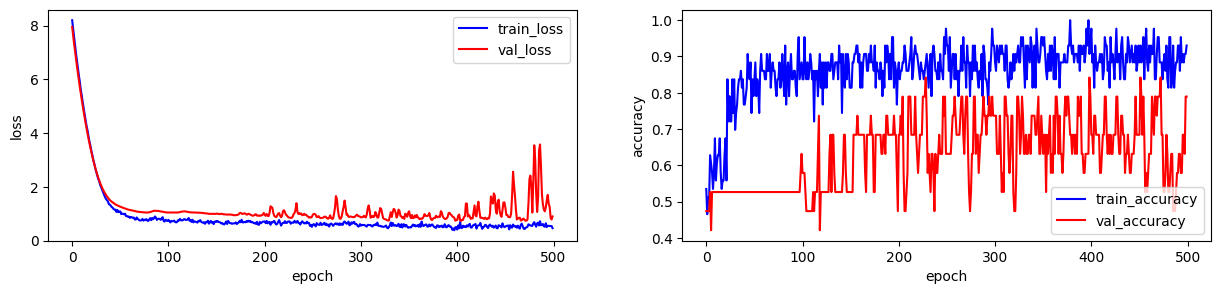

In [99]:
train_test_curves(hist_Balanced_CNNBest)

# Selecting best model and visualization

In [100]:
# Load Model
model = load_model("BestModel.h5")

# make predictions with model
y_pred = np.argmax(model.predict(x_test),axis=1)

In [101]:
cf_matrix = confusion_matrix(y_test[:,0], y_pred)

## Confusion Matrix

[]

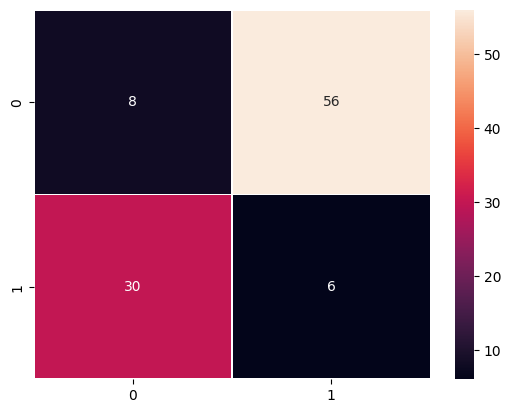

In [102]:
sns.heatmap(cf_matrix, linewidths=.5,annot=True)
plt.plot()

# Class activation map

In [103]:
from IPython.core.pylabtools import figsize
from mpl_toolkits.axes_grid1 import Divider, Size

def class_activation_map(model, sample, label):
  # the label is the class we want to predict and explain
  # this function applies the class activation map algorithm
  
  # get the weights that bind the filter k to a class c
  w_k_c = model.layers[-1].get_weights()[0]
  
  # we will build a model that is exactly like the one we
  # just built but the last layer will be the one above
  # the global average pooling
  
  # define the entry of the new model which is the same as the old one
  new_input_layer = [model.layers[0].input]
  
  # set the output which is A_(x,y)
  new_output_layer = [model.layers[-3].output]
  
  # define the new model (which does not require training)
  new_model = keras.backend.function(new_input_layer, new_output_layer)
  
  # create figure
  plt.figure()
  
  # compute A_k (x,y)
  A_k = new_model([sample.reshape(1,sample.shape[0],sample.shape[1])])[0]
  
  # create the cam which has the same shape as an image without the RGBs
  cam = np.zeros(dtype=np.float,shape=sample.shape[:1])
  
  # loop to calculate the product
  # enter w_k_c with A_k for each k
  for k,w in enumerate(w_k_c[:, label]):
    cam = cam + w * A_k[0, :, k]
  
  cam = cam.astype(int)
  fig,axs = plt.subplots(2,figsize=(10,5))
  
  axs[0].plot(sample)
  axs[1].scatter(np.arange(len(sample)),sample,c=cam,s=10);

  colors = [mcolors.to_rgba(c)
          for c in plt.rcParams['axes.prop_cycle'].by_key()['color']]
  segs = np.zeros((50, 100, 2))
  line_segments = LineCollection(segs, linewidths=(0.5, 1, 1.5, 2),
                               colors=colors, linestyle='solid')
  # plt.colorbar(line_segments)
  plt.colorbar(line_segments,orientation='horizontal')

  plt.plot()

<Figure size 640x480 with 0 Axes>

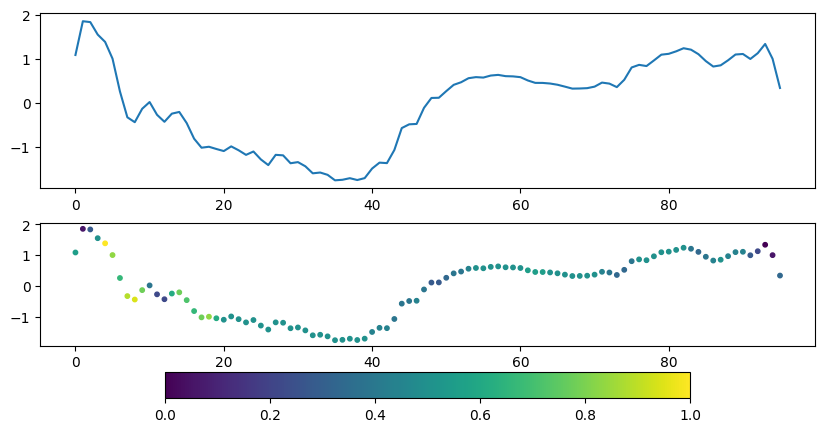

In [104]:
from scipy.interpolate import make_interp_spline
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors

# choose Data
idx = 6

original_sample = x_train[idx]
# label = np.argmax(y_train[idx])
model = load_model('CNNmodelN1.h5')

class_activation_map(model,x_test[idx],int(y_train[idx][0]))